In [16]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

def set_mixed_precision(enable_amp: bool):
    if enable_amp:
        tf.keras.mixed_precision.set_global_policy("mixed_float16")
        print("AMP habilitado (mixed_float16).")
    else:
        tf.keras.mixed_precision.set_global_policy("float32")
        print("AMP deshabilitado.")

In [17]:
IMG_SIZE = 224
BATCH = 64
EPOCHS = 10
LR = 3e-4
WEIGHT_DECAY = 1e-4
LABEL_SMOOTH = 0.0
FREEZE_BACKBONE = True
USE_AMP = True

set_mixed_precision(USE_AMP)


AMP habilitado (mixed_float16).


In [18]:
# Carga CIFAR-10
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
y_train = y_train.squeeze()
y_test  = y_test.squeeze()

# Filtro binario: cat=3, dog=5 -> mapeamos a {0: cat, 1: dog}
def filter_cats_dogs(x, y):
    mask = np.isin(y, [3, 5])
    x = x[mask]
    y = y[mask]
    y = (y == 5).astype(np.int32)  # 0=cat, 1=dog
    return x, y

x_train, y_train = filter_cats_dogs(x_train, y_train)
x_test,  y_test  = filter_cats_dogs(x_test,  y_test)

# Split validación desde train (80/20)
n = len(x_train)
idx = np.random.permutation(n)
split = int(0.8 * n)
tr_idx, val_idx = idx[:split], idx[split:]
x_val, y_val = x_train[val_idx], y_train[val_idx]
x_train, y_train = x_train[tr_idx], y_train[tr_idx]

class_names = ["cat", "dog"]
print("Train:", x_train.shape, np.bincount(y_train))
print("Val:  ", x_val.shape,   np.bincount(y_val))
print("Test: ", x_test.shape,  np.bincount(y_test))


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 16s 0us/step
Train: (8000, 32, 32, 3) [3993 4007]
Val:   (2000, 32, 32, 3) [1007  993]
Test:  (2000, 32, 32, 3) [1000 1000]


In [19]:
from tensorflow.keras import layers

AUTOTUNE = tf.data.AUTOTUNE
Preprocess = tf.keras.applications.resnet50.preprocess_input

# Aumentos ligeros
augment = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
], name="augment")

def make_ds(x, y, train=True):
    y = tf.one_hot(y, depth=2)
    ds = tf.data.Dataset.from_tensor_slices((x, y))
    if train:
        ds = ds.shuffle(10000, seed=SEED)
    # Casting + resize + augment + preprocess
    def _map(img, label):
        img = tf.cast(img, tf.float32)
        img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
        if train:
            img = augment(img, training=True)
        img = Preprocess(img)
        return img, label
    ds = ds.map(_map, num_parallel_calls=AUTOTUNE).batch(BATCH).prefetch(AUTOTUNE)
    return ds

train_ds = make_ds(x_train, y_train, train=True)
val_ds   = make_ds(x_val,   y_val,   train=False)
test_ds  = make_ds(x_test,  y_test,  train=False)


In [20]:
counts = np.bincount(y_train, minlength=2).astype(np.float32)
total = counts.sum()
weights = (1.0 / np.maximum(counts, 1.0)) * (total / len(counts))
class_weight = {i: float(w) for i, w in enumerate(weights)}
print("Class weights:", class_weight)


Class weights: {0: 1.0017529726028442, 1: 0.9982529878616333}


In [21]:
from tensorflow.keras import models

base = tf.keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)
base.trainable = not FREEZE_BACKBONE

inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base(inputs, training=False)          # BN en modo inference al inicio
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.25)(x)
dtype_head = "float32" if tf.keras.mixed_precision.global_policy().name == "mixed_float16" else None
outputs = layers.Dense(2, activation="softmax", dtype=dtype_head)(x)
model = models.Model(inputs, outputs)
model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │         4,098 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,591,810 (90.00 MB)

 Trainable params: 4,098 (16.01 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [22]:
optimizer = tf.keras.optimizers.AdamW(learning_rate=LR, weight_decay=WEIGHT_DECAY)
loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=LABEL_SMOOTH)
metrics = [
    tf.keras.metrics.CategoricalAccuracy(name="acc"),
    tf.keras.metrics.AUC(name="auc"),
    tf.keras.metrics.Precision(name="precision"),
    tf.keras.metrics.Recall(name="recall"),
]
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)


In [23]:
ckpt_path = "best_resnet_catsdogs.keras"
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(ckpt_path, monitor="val_acc", mode="max",
                                       save_best_only=True, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor="val_acc", mode="max",
                                     patience=4, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.2,
                                         patience=2, verbose=1, min_lr=1e-7),
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    class_weight=class_weight,
    callbacks=callbacks
)


Epoch 1/10


2025-09-05 06:03:57.300477: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 102760448 exceeds 10% of free system memory.
2025-09-05 06:03:57.524074: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 205520896 exceeds 10% of free system memory.
2025-09-05 06:03:57.669484: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 102760448 exceeds 10% of free system memory.
2025-09-05 06:03:57.767490: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 106463232 exceeds 10% of free system memory.
2025-09-05 06:03:57.890797: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 102760448 exceeds 10% of free system memory.


125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - acc: 0.6650 - auc: 0.7228 - loss: 0.6924 - precision: 0.6650 - recall: 0.6650
Epoch 1: val_acc improved from -inf to 0.85400, saving model to best_resnet_catsdogs.keras
125/125 ━━━━━━━━━━━━━━━━━━━━ 676s 5s/step - acc: 0.6656 - auc: 0.7236 - loss: 0.6912 - precision: 0.6656 - recall: 0.6656 - val_acc: 0.8540 - val_auc: 0.9312 - val_loss: 0.3339 - val_precision: 0.8540 - val_recall: 0.8540 - learning_rate: 3.0000e-04
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - acc: 0.8277 - auc: 0.9113 - loss: 0.3814 - precision: 0.8277 - recall: 0.8277
Epoch 2: val_acc improved from 0.85400 to 0.87800, saving model to best_resnet_catsdogs.keras
125/125 ━━━━━━━━━━━━━━━━━━━━ 660s 5s/step - acc: 0.8278 - auc: 0.9113 - loss: 0.3812 - precision: 0.8278 - recall: 0.8278 - val_acc: 0.8780 - val_auc: 0.9476 - val_loss: 0.2927 - val_precision: 0.8780 - val_recall: 0.8780 - learning_rate: 3.0000e-04
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - acc: 0.8546

In [25]:
if FREEZE_BACKBONE:
    print("Descongelando ~último 30% de capas para afinar…")
    # 1) Descongela las capas más profundas
    n = len(base.layers)
    for i, layer in enumerate(base.layers):
        layer.trainable = (i > int(0.7 * n))

    # 2) Bajar el LR de forma robusta (funciona con AMP / LossScaleOptimizer)
    def set_optimizer_lr(model, new_lr):
        opt = model.optimizer
        # Si está envuelto (mixed precision), toma el optimizador interno
        inner = getattr(opt, "inner_optimizer", opt)

        # Intento A: asignar si es variable
        lr_attr = getattr(inner, "learning_rate", None)
        if hasattr(lr_attr, "assign"):
            try:
                lr_attr.assign(new_lr)
                print(f"LR actualizado vía .assign a {float(new_lr)}")
                return
            except Exception as e:
                print("No se pudo asignar LR directamente:", e)

        # Intento B: recrear el optimizador con mismo tipo/config pero nuevo LR
        OptimClass = type(inner)
        try:
            cfg = inner.get_config()
        except Exception:
            cfg = {}
        cfg.update({"learning_rate": new_lr})
        new_inner = OptimClass(**cfg) if cfg else OptimClass(learning_rate=new_lr)

        # Reaplica wrapper de mixed precision si existía
        if hasattr(opt, "inner_optimizer"):
            from tensorflow.keras.mixed_precision import LossScaleOptimizer
            new_opt = LossScaleOptimizer(new_inner)
        else:
            new_opt = new_inner

        model.compile(optimizer=new_opt, loss=model.loss, metrics=model.metrics)
        print(f"LR actualizado recreando optimizer a {float(new_lr)}")

    set_optimizer_lr(model, LR * 0.1)

    # 3) Entrenamiento de fine-tuning
    history_ft = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=max(3, EPOCHS // 2),
        class_weight=class_weight,
        callbacks=callbacks
    )
else:
    print("El backbone ya estaba entrenable; puedes continuar entrenando bajando el LR si lo deseas.")


Descongelando ~último 30% de capas para afinar…
LR actualizado vía .assign a 2.9999999999999997e-05
Epoch 1/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - acc: 0.8899 - auc: 0.9618 - loss: 0.2498 - precision: 0.8899 - recall: 0.8899
Epoch 1: val_acc did not improve from 0.89850
125/125 ━━━━━━━━━━━━━━━━━━━━ 773s 6s/step - acc: 0.8899 - auc: 0.9618 - loss: 0.2498 - precision: 0.8899 - recall: 0.8899 - val_acc: 0.8940 - val_auc: 0.9653 - val_loss: 0.2390 - val_precision: 0.8940 - val_recall: 0.8940 - learning_rate: 3.0000e-05
Epoch 2/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - acc: 0.8874 - auc: 0.9596 - loss: 0.2573 - precision: 0.8874 - recall: 0.8874
Epoch 2: val_acc did not improve from 0.89850
125/125 ━━━━━━━━━━━━━━━━━━━━ 1147s 9s/step - acc: 0.8874 - auc: 0.9596 - loss: 0.2573 - precision: 0.8874 - recall: 0.8874 - val_acc: 0.8950 - val_auc: 0.9652 - val_loss: 0.2391 - val_precision: 0.8950 - val_recall: 0.8950 - learning_rate: 3.0000e-05
Epoch 3/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/st

== Evaluación en test ==
loss: 0.2380
compile_metrics: 0.8995


2025-09-05 09:10:07.049313: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



== Reporte de clasificación ==
              precision    recall  f1-score   support

         cat     0.8983    0.9010    0.8997      1000
         dog     0.9007    0.8980    0.8993      1000

    accuracy                         0.8995      2000
   macro avg     0.8995    0.8995    0.8995      2000
weighted avg     0.8995    0.8995    0.8995      2000

Matriz de confusión:
 [[901  99]
 [102 898]]


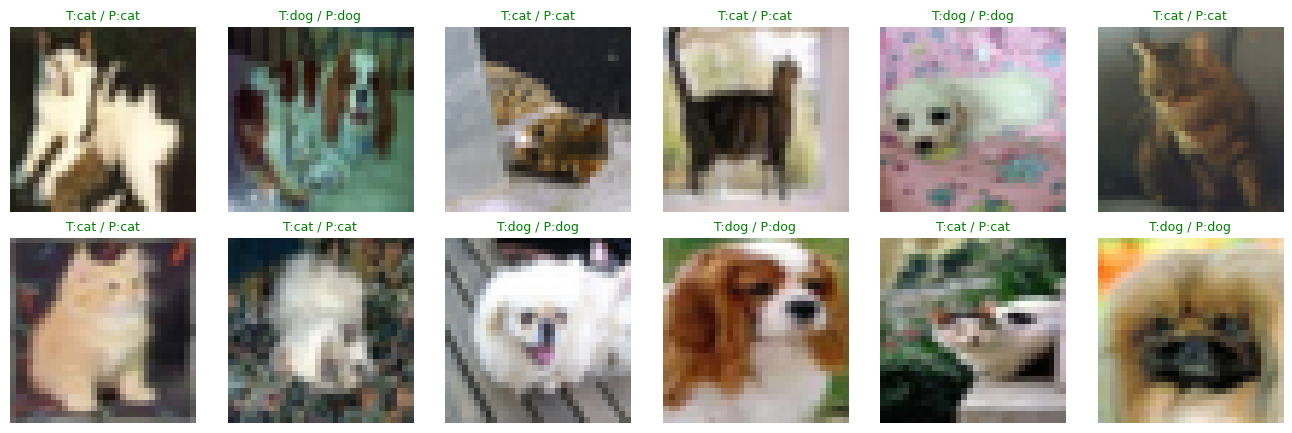

In [26]:
print("== Evaluación en test ==")
test_metrics = model.evaluate(test_ds, verbose=0)
for name, val in zip(model.metrics_names, test_metrics):
    print(f"{name}: {val:.4f}")

# Predicciones
y_true = y_test
probs = np.concatenate([model.predict(bx, verbose=0) for bx, _ in test_ds])
y_pred = probs.argmax(axis=1)

print("\n== Reporte de clasificación ==")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))
cm = confusion_matrix(y_true, y_pred, labels=[0,1])
print("Matriz de confusión:\n", cm)

# Visual rápido de algunas predicciones
def show_samples(x, y_true, y_pred, n=12):
    idx = np.random.choice(len(x), size=n, replace=False)
    cols = 6
    rows = int(np.ceil(n / cols))
    plt.figure(figsize=(cols*2.2, rows*2.2))
    for i, j in enumerate(idx):
        ax = plt.subplot(rows, cols, i+1)
        plt.imshow(x[j])
        t = class_names[y_true[j]]
        p = class_names[y_pred[j]]
        color = "green" if y_true[j] == y_pred[j] else "red"
        ax.set_title(f"T:{t} / P:{p}", color=color, fontsize=9)
        ax.axis("off")
    plt.tight_layout()
    plt.show()

show_samples(x_test, y_true, y_pred, n=12)
